In [1]:
%%js
var cells = Jupyter.notebook.get_cells();
           for (var i = 0; i < cells.length; i++) {
               var cur_cell = cells[i];
               var tags = cur_cell._metadata.tags;
               console.log(i);
               console.log(tags == undefined);
               console.log(tags);
               if (tags != undefined) {
               for (var j = 0; j < tags.length; j++) {
                  if (tags[j]=="book_only" | tags[j]=="remove-cell") {cur_cell.element.hide();}}
               for (var j = 0; j < tags.length; j++) {
                   if (tags[j]=="presentation_only") {cur_cell.element.show();}}
            }}

<IPython.core.display.Javascript object>

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.signal as sig
from scipy.integrate import simpson
from IPython.display import SVG, display, IFrame, HTML
import seaborn as sns
import torch
from scipy import ndimage
from scipy import misc
%matplotlib notebook
book = False

C:\Users\meyjoh\repos\vlcompimg\compimg\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
%matplotlib inline
book = True

In [4]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [5]:
%%javascript

MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [6]:
def showFig(path,i,ending, width, height):
    filename = path+str(i)+ending
    return HTML("<img src=\"" + filename +  f"\" style=\"max-height:{height}vh\"/>")

In [7]:
def showFig2(path,i,ending, width, height):
    imgToShow = plt.imread(f"{path}{i}{ending}")
    plt.imshow(imgToShow)

In [8]:
def imshow(img, cmap=None):
    plt.close('all')
    plt.figure()
    plt.imshow(img, cmap=cmap)
    plt.show()

In [9]:
def imshow2(img, cmap=None):
    #plt.close('all')
    #plt.figure()
    plt.clf()
    plt.imshow(img, cmap=cmap)
    #plt.show()

$\begin{align}
  \newcommand{transp}{^\intercal}
  \newcommand{F}{\mathcal{F}}
  \newcommand{Fi}{\mathcal{F}^{-1}}
  \newcommand{inv}{^{-1}}
  \newcommand{stochvec}[1]{\mathbf{\tilde{#1}}}
  \newcommand{argmax}[1]{\underset{#1}{\mathrm{arg\, max}}\,}
  \newcommand{argmin}[1]{\underset{#1}{\mathrm{arg\, min}}\,}
\end{align}$

<font size="7"> Computational Imaging </font><br><br><br>

# Coded Exposure Photography

##### Content
* Introduction into coded exposure photography
* Optical setup for coded exposure photography
* Selection of encoding pattern
* Reconstruction
* Example

## Introduction into coded exposure photography

When photographing dynamic scenes, moving objects can cause so-called *motion blur* in the captured image depending on the exposure time of the camera.

When an object moves during exposure time, its image is smeared over an image region depending on its movement trajectory and its pixel values are blended with those of the stationary background.

The obvious way to mitigate or prevent motion blur is to reduce the exposure time and compensate the reduced light efficiency via:
* increased digital amplification (at the cost of amplified noise) or
* by providing sufficient artificial illumination (e.g., flashes).

In this chapter, we will explore a different approach to compensate motion blur that is based on deconvolution. The presented content is based on the paper [Coded Exposure Photography: Motion Deblurring using Fluttered Shutter](https://web.media.mit.edu/~raskar/deblur/CodedExpousreLowres.pdf) by Ramesh Raskar et al..

### Image formation model for motion blur

Assume that the observed scene consists of one object moving linearly along some direction with constant speed (can analogously be extended to multiple objects) in front of a black background (i.e., which reflects no light). 

The corresponding image formation of the blurred observation $g$ can be modeled via a convolution of the sought sharp image $x$ of the object with the motion blur kernel $h$ and some additive noise $n$:

$\begin{align} 
   g = x*h + n \,.
\end{align}$

The motion blur kernel $h$ then consists of a one-dimensional $\mathrm{rect}$-function with a width corresponding to the number of pixels that the image of the object moves on the image sensor during one exposure period. The orientation of the $\mathrm{rect}$-function corresponds to the direction of the linear movement.

##### Example
The following shows a simple example of simulated motion blur:

<img src="figures/8/example_convolution_motion_blur.svg" style="max-height:40vh">

The motion blur kernel $h$ can be modeled as a rotated and translated $\mathrm{rect}$-function:

<img src="figures/8/blur_kernel_line_section.svg" style="max-height:40vh">

Directly trying to reconstruct the latent image $x$ based on such an observation would lead to strong artifacts.

This can be seen explained in two ways:

1. The Fourier transform of the $\mathrm{rect}(x)$-function is given by $\mathrm{sinc}(x)=\frac{\sin x}{x}$; see the following Figure for a visualization of its graph (logarithm of magnitude of Fourier transform):

<img src="figures/8/rect_fourier_sinc.svg" style="max-height:40vh">

The spectrum of the $\mathrm{sinc}$-function is not flat and has many zeros where information is inevitably lost. Inverting a such a deconvolution would strongly amplify certain frequencies (at the positions of the zeros) and hence might also amplify unwanted noise.

2. The autocorrelation of the $\mathrm{rect}$-function does not resemble a Dirac-like what is hindering for the reconstruction.

As a consequence, a better encoding strategy has to be found.

## Optical setup for coded exposure photography

In order to control the exposure modulation, an existing camera can be extended via a programmable shutter that is synchronized with the exposure control of the camera.

In the referenced paper, the authors use a programmable LCD as a spatial light modulator placed in front of the main lens of a digital lens reflex camera and simultaneously turn all pixels transparent or opaque to realize an encoding of the exposure.

The whole exposure period $T$ of the camera can be divided into $M$ time slices, so-called *chops* with duration $T/M$.

During each chop, the LCD-based shutter is either set to transparent or opaque as stated in a corresponding pattern vector $\mathbf{p}\in \left\{ 0,1 \right\}^M $

## Selection of encoding pattern $\mathbf{p}$

When searching for an optimal code, two mutual criteria have to be optimized:
1. Invertibility (i.e., flat Fourier spectrum and as few zeros as possible), 
2. light efficiency (i.e., many ones in $\mathbf{p}$).

One possibility to ensure light efficiency is to fix the ratio of ones and zeros in $\mathbf{p}$ to $1:1$.

For a given number $M$ of chops, this design decision sets the set of possible encoding candidates which could be evaluated with respect to criterion 1 (invertibility) in a brute force manner.

This has been done by the authors of the referenced paper by means of a randomized linear search for $M=52$. 

The resulting encoding is
$\begin{align} 
   \mathbf{p} = (1010000111000001010000110011110111010111001001100111)\transp \,.
\end{align}$

The logarithm of the magnitude of the spectrum of that code is shown below (for positive spatial frequencies):

<img src="figures/8/encoding_spectrum.svg" style="max-height:40vh">

## Reconstruction

The reconstruction can be performed with any suitable deconvolution method (Wiener filter, iterative methods, data-driven methods).

When applied in a practical scenario, there are two open points which have to be addressed:
1. The orientation of the encoding line in the motion blur kernel $h$ has to be determined.
2. Different regions in the image can be affected by different types of motion blur, i.e., different directions, different movement velocities, no movement (e.g., background) and those regions can also be blended with each other.

Point 1 can be solved by prompting the user to estimate the movement direction and length (in pixels).

Both points can be addressed simultaneously by employing methods for locally estimating the blur PSF, i.e., with respect to the pixel position.

## Example

Consider again the following example image:

<img src="figures/8/tree.png" style="max-height:40vh">

We simulate a horizontal motion blur by convolving with a 52 pixel width conventional $\mathrm{rect}$-like kernel and with kernel encoded according to the previously mentioned pattern:

<img src="figures/8/observation_motion_blur_different_kernels.svg" style="max-height:40vh">

For both images, we add Gaussian noise of different levels and try to reconstruct the undistorted image with a Wiener filter using the introduced heuristic for estimating the signal-to-noise ratio.

By this means, we achieve the following qualitative results:

In [10]:
interact(lambda i: showFig('figures/8/motion_deblur_results_',i,'.svg',800,50), i=widgets.IntSlider(min=(min_i:=0),max=(max_i:=5), step=1, value=(max_i if book else min_i)))

interactive(children=(IntSlider(value=5, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(i)>

The results can be evaluated quantitatively by calculating the root mean squared reconstruction error with respect to the undistorted image:

<img src="figures/8/reconstruction_rmse.svg" style="max-height:40vh">

##### Archive

In [11]:
h = plt.imread("figures/8/example_motion_blur_2.png")

In [12]:
h.shape

(71, 71)

img = np.float32(misc.face(gray=True))

In [13]:
img = plt.imread("figures/8/tree.png")

In [14]:
img_blurred = ndimage.convolve(img, h, mode='wrap')

In [15]:
plt.imsave("figures/8/example_motion_blur_tree.png", img_blurred, cmap='gray')

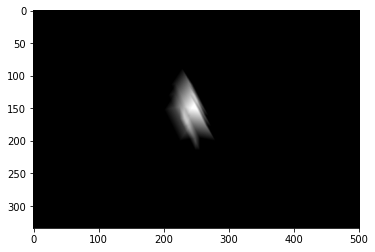

In [16]:
imshow(img_blurred, cmap='gray')

In [17]:
def mag_square(inp : np.ndarray):
    return inp.real**2 + inp.imag**2

In [18]:
xs = np.linspace(-3, 3, 1001)
ys = np.zeros_like(xs)
ys[(xs >= -1) & (xs <= 1)] = 1

In [19]:
ys = np.array([1,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,1,1,1,0,1,1,1,0,1,0,1,1,1,0,0,1,0,0,1,1,0,0,1,1,1])
ys = np.pad(ys, (100,101))
xs = np.arange(0,len(ys))
xs = xs - int(len(xs)/2)

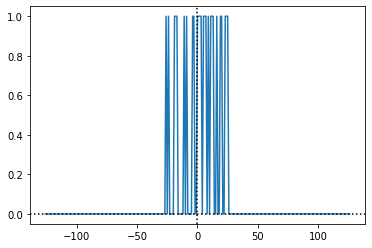

In [20]:
plt.figure()
plt.plot(xs,ys)
plt.axhline(0, color='k', linestyle=":")
plt.axvline(0, color='k', linestyle=":")

In [21]:
plt.savefig("rect.svg")

<Figure size 432x288 with 0 Axes>

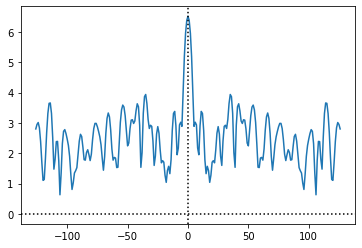

In [22]:
plt.figure()
plt.plot(xs,(np.log(mag_square(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(ys)))))))
plt.axhline(0, color='k', linestyle=":")
plt.axvline(0, color='k', linestyle=":")

In [23]:
plt.savefig("code_spectrum.svg")

<Figure size 432x288 with 0 Axes>

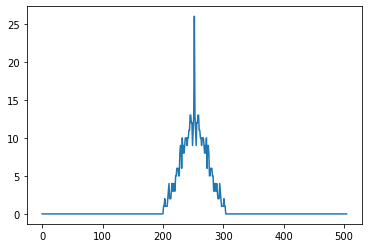

In [24]:
plt.figure()
plt.plot(np.correlate(ys,ys, mode="full"))

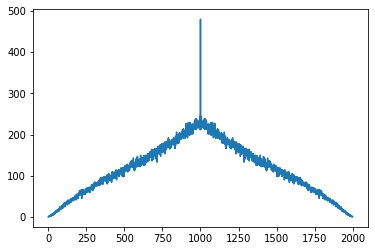

In [25]:
plt.figure()
ys2 = np.random.randint(0,2,1001)
plt.plot(np.correlate(ys2,ys2, mode="full"))

In [26]:
def make_odd_shapes(inp : np.ndarray) -> np.ndarray:
    if (inp.shape[0] % 2 == 0):
        inp = inp[0:-1,:]
    if (inp.shape[1] % 2 == 0):
        inp = inp[:,0:-1]
    return inp

In [27]:
def pad_like(inp : np.ndarray, like : np.ndarray):
    to_pad = tuple(np.int32((np.array(like.shape) - np.array(inp.shape))/2))
    return np.pad(inp, ((to_pad[0], to_pad[0]), (to_pad[1], to_pad[1])))

In [28]:
def wiener_filter(g:np.ndarray, h:np.ndarray) -> np.ndarray:
    g_fft = np.fft.fft2(g)
    h_padded = pad_like(h, g)
    h_fft = np.fft.fft2(np.fft.ifftshift(h_padded))
    
    X,Y = np.meshgrid(np.arange(1,g.shape[1]+1), np.arange(1,g.shape[0]+1))
    
    snr = (1 / np.sqrt(X**2 + Y**2))
    
    inv_fft = g_fft * np.conjugate(h_fft) / (mag_square(h_fft) + snr)
    return np.real(np.fft.ifft2(inv_fft))

In [29]:
h_encoded = np.array([1,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,1,1,1,0,1,1,1,0,1,0,1,1,1,0,0,1,0,0,1,1,0,0,1,1,1])
h_normal = np.ones_like(h_encoded)

h_encoded = np.pad(h_encoded, (2,1))
h_normal = np.pad(h_normal, (2,1))

h_encoded = np.vstack((np.zeros_like(h_encoded),h_encoded, np.zeros_like(h_encoded)))
h_normal = np.vstack((np.zeros_like(h_normal),h_normal, np.zeros_like(h_normal)))

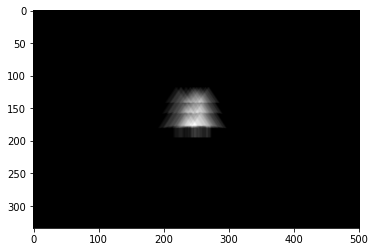

In [30]:
imshow(ndimage.convolve(img, h_encoded), cmap='gray')

In [31]:
img = make_odd_shapes(img)*255

In [32]:
sigmas = np.float32(np.array([0,2,4,8,16,32]))  # Standard deviations for Gaussian noise
noises = []   # List for observations
for sigma in sigmas:
    cur_img = np.random.normal(0, sigma, img.shape)
    noises.append(cur_img)

In [33]:
normal_recs = []
normal_rms = []
encoded_recs = []
encoded_rms = []

for noise in noises:
    g_normal = ndimage.convolve(img, h_normal) + noise
    g_encoded = ndimage.convolve(img, h_encoded) + noise
    
    rec_normal = wiener_filter(g_normal, h_normal)
    rec_encoded = wiener_filter(g_encoded, h_encoded)
    
    normal_recs.append(rec_normal)
    encoded_recs.append(rec_encoded)
    
    normal_rms.append(np.sum(np.sqrt((rec_normal - img)**2)))
    encoded_rms.append(np.sum(np.sqrt((rec_encoded - img)**2)))

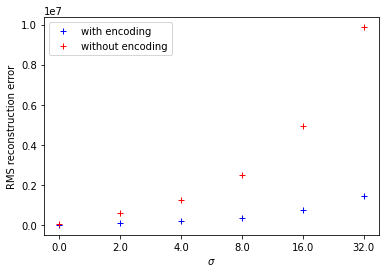

In [34]:
plt.figure()
plt.plot(encoded_rms, 'b+', label="with encoding")
plt.plot(normal_rms, 'r+', label="without encoding")
plt.xticks(np.arange(0,len(sigmas)), sigmas)
plt.xlabel("$\sigma$")
plt.ylabel("RMS reconstruction error")
plt.legend()
plt.savefig("reconstruction_rmse.svg")

In [35]:
def show_reconst(i):
    plt.subplot(1,2,1)
    plt.imshow(normal_recs[i], cmap='gray')
    plt.title(f"Reconstruction for\n conventional kernel\n for $\sigma$ = {sigmas[i]}")
    plt.subplot(1,2,2)
    plt.imshow(encoded_recs[i], cmap='gray')
    plt.title(f"Reconstruction for\n encoding kernel\n for $\sigma$ = {sigmas[i]}")

In [36]:
plt.figure()
interact(lambda i: show_reconst(i), i=widgets.IntSlider(min=(min_i:=0),max=(max_i:=len(encoded_recs)-1), step=1, value=(max_i if book else min_i)))

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=5, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(i)>

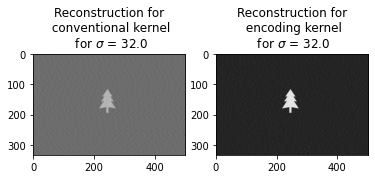

In [37]:
plt.figure()
for i in range(0,len(encoded_recs)):
    show_reconst(i)
    plt.savefig(f"motion_deblur_results_{i}.svg")

Text(0.5, 1.0, 'Observed image for\n encoded kernel')

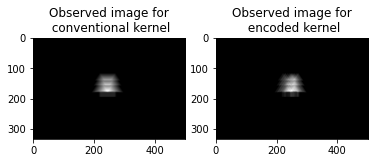

In [38]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(ndimage.convolve(img, h_normal), cmap='gray')
plt.title(f"Observed image for\n conventional kernel")
plt.subplot(1,2,2)
plt.imshow(ndimage.convolve(img, h_encoded), cmap='gray')
plt.title(f"Observed image for\n encoded kernel")

In [39]:
plt.savefig("observation_motion_blur_different_kernels.svg")

<Figure size 432x288 with 0 Axes>